# 観光地選択巡回問題

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pulp

## ランダムインスタンス

In [65]:
# 範囲
R = 50

# 観光地候補数
N = np.random.randint(30, 40)

# 観光地候補集合
I = [i for i in range(N)]
start = I[0]

# 観光地の満足度
a = np.random.randint(1, 5, N)

# 観光地の滞在時間
b = np.random.randint(1, 2, N)

# 観光地候補間の移動距離(時間)
pos = np.random.randint(-R, R, (N, 2))  # 座標
speed = 40
d = [[np.linalg.norm(pos_i - pos_j, ord=2) / speed for pos_i in pos] for pos_j in pos]

# 観光費用(とりあえず0円)
c = np.zeros(N)

# 観光候補地間の交通費(とりあえず0円)
m = np.zeros((N, N), dtype=np.int)

# 観光制限時間
T = 10

# 観光制限費用(とりあえず0円)
C = 0

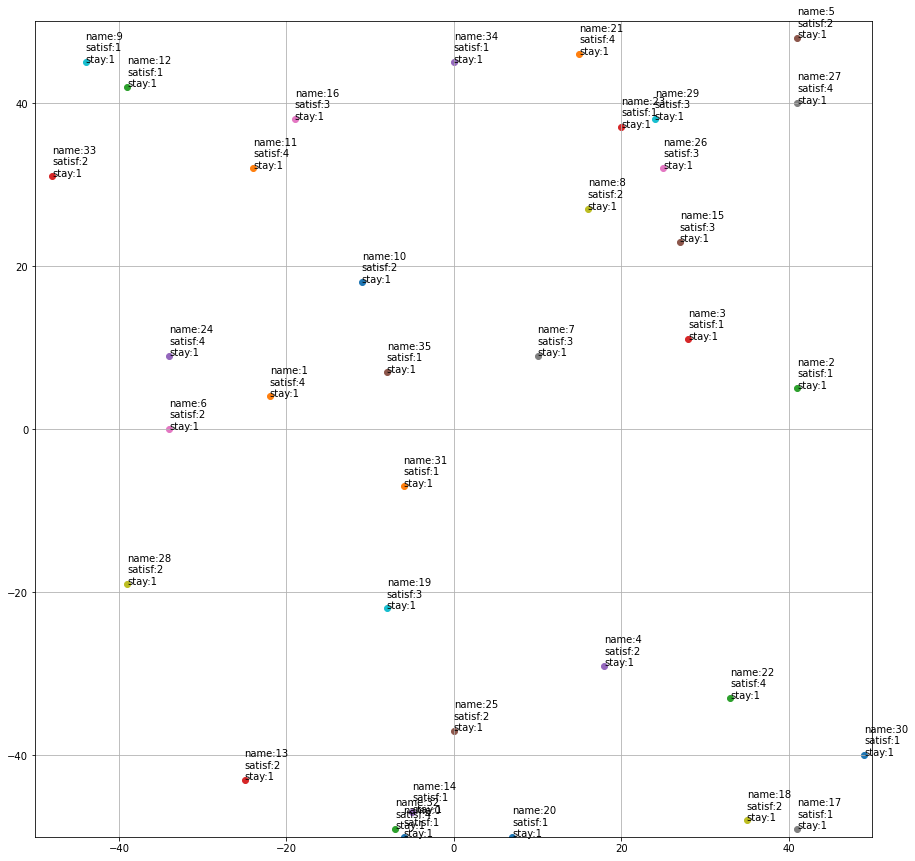

In [66]:
plt.figure(figsize=(15,15))

for pos_i, name_i, a_i, b_i in zip(pos, map(str, I), map(str, a), map(str, b)):
    plt.scatter(pos_i[0], pos_i[1])
    plt.annotate(f'name:{name_i}\nsatisf:{a_i}\nstay:{b_i}',
                 xy=(pos_i[0], pos_i[1]))

plt.xlim([-R,R])
plt.ylim([-R,R])
plt.grid()
plt.show()

## モデルの定義

In [67]:
# 数理最適化問題（最大化）を宣言
problem = pulp.LpProblem("problem", pulp.LpMaximize)

# 変数を定義
y = {}
for i in I:
    y[i] = pulp.LpVariable(f'y_{i}', 0, 1, pulp.LpInteger)

x = {}
for i in I:
    for j in I:
        if i != j:
            x[i,j] = pulp.LpVariable(f'x({i},{j})', 0, 1, pulp.LpInteger)
# 別表記
# x_suffixes = [(i,j) for i in I for j in I if i != j]
# x = pulp.LpVariable.dicts("x", 
#                           filter(lambda x: x != 0 ,x_suffixes), 
#                           cat = pulp.LpBinary)

f = {}
for i in I:
    for j in I:
        if i != j:
            f[i,j] = pulp.LpVariable(f'f({i},{j})', 0, N, pulp.LpInteger)

# 目的関数
objective = pulp.lpSum(a[i] * y[i] for i in I)
problem += objective

# 制約条件
## 時間制約
problem += sum(d[i][j] * x[i,j] for i in I for j in I if i != j) +\
            sum(b[i] * y[i] for i in I) <= T

## 費用制約
problem += sum(m[i][j] * x[i,j] for i in I for j in I if i != j) +\
            sum(c[i] * y[i] for i in I) <= C

## 観光地を訪れるのは各１回
for i in I:
    problem += sum(x[i,j] for j in I if i != j) == y[i]

for j in I:
    problem += sum(x[i,j] for i in I if i != j) == y[j]
    
## 部分巡回路を排除
for i in I:
    if i == start:
        for j in I:
            if i != j:
                problem += f[i,j] == 0
        continue
    
    problem += sum(f[h,i] for h in I if i != h) + y[i] == sum(f[i,j] for j in I if i != j)

for i in I:
    for j in I:
        if i != j:
            problem += f[i,j] <= N * x[i,j]

## スタート地点を必ず通るようにする
problem += y[start] == 1

In [68]:
print("問題の式")
print(f"-" * 8)
print(problem)
print(f"-" * 8)
print("")

問題の式
--------
problem:
MAXIMIZE
1*y_0 + 4*y_1 + 2*y_10 + 4*y_11 + 1*y_12 + 2*y_13 + 1*y_14 + 3*y_15 + 3*y_16 + 1*y_17 + 2*y_18 + 3*y_19 + 1*y_2 + 1*y_20 + 4*y_21 + 4*y_22 + 1*y_23 + 4*y_24 + 2*y_25 + 3*y_26 + 4*y_27 + 2*y_28 + 3*y_29 + 1*y_3 + 1*y_30 + 1*y_31 + 4*y_32 + 2*y_33 + 1*y_34 + 1*y_35 + 2*y_4 + 2*y_5 + 2*y_6 + 3*y_7 + 2*y_8 + 1*y_9 + 0
SUBJECT TO
_C1: 1.40801278403 x(0,1) + 1.70458939337 x(0,10) + 2.09880918618 x(0,11)
 + 2.44348623896 x(0,12) + 0.506211418283 x(0,13) + 0.0790569415042 x(0,14)
 + 2.00281052524 x(0,15) + 2.22387612065 x(0,16) + 1.17526592735 x(0,17)
 + 1.02621878759 x(0,18) + 0.701783442381 x(0,19) + 1.80865972477 x(0,2)
 + 0.325 x(0,20) + 2.45675090312 x(0,21) + 1.06360236931 x(0,22)
 + 2.27004955893 x(0,23) + 1.63267418673 x(0,24) + 0.357945526582 x(0,25)
 + 2.19160329439 x(0,26) + 2.53833114467 x(0,27) + 1.13192314227 x(0,28)
 + 2.32432785983 x(0,29) + 1.74588802619 x(0,3) + 1.39754248594 x(0,30)
 + 1.075 x(0,31) + 0.0353553390593 x(0,32) + 2.28103594886 x(

In [69]:
solver = pulp.PULP_CBC_CMD()
result_status = problem.solve(solver)

In [70]:
print("計算結果")
print(f"*" * 8)
print(f"最適性 = {pulp.LpStatus[result_status]}, ", end="")
print(f"目的関数値 = {pulp.value(problem.objective)}, ", end="")
print("解 x[i,j]: ")
for i in I:
    for j in I:
        if i != j:
            print(f"{x[i,j].name} = {x[i,j].value()},  ", end="")
    print("")
for i in I:
    print(f"{y[i].name} = {y[i].value()},  ", end="")
print(f"*" * 8)

計算結果
********
最適性 = Optimal, 目的関数値 = 18.0, 解 x[i,j]: 
x(0,1) = 0.0,  x(0,2) = 0.0,  x(0,3) = 0.0,  x(0,4) = 0.0,  x(0,5) = 0.0,  x(0,6) = 0.0,  x(0,7) = 0.0,  x(0,8) = 0.0,  x(0,9) = 0.0,  x(0,10) = 0.0,  x(0,11) = 0.0,  x(0,12) = 0.0,  x(0,13) = 0.0,  x(0,14) = 0.0,  x(0,15) = 0.0,  x(0,16) = 0.0,  x(0,17) = 0.0,  x(0,18) = 0.0,  x(0,19) = 0.0,  x(0,20) = 0.0,  x(0,21) = 0.0,  x(0,22) = 0.0,  x(0,23) = 0.0,  x(0,24) = 0.0,  x(0,25) = 0.0,  x(0,26) = 0.0,  x(0,27) = 0.0,  x(0,28) = 0.0,  x(0,29) = 0.0,  x(0,30) = 0.0,  x(0,31) = 0.0,  x(0,32) = 1.0,  x(0,33) = 0.0,  x(0,34) = 0.0,  x(0,35) = 0.0,  
x(1,0) = 0.0,  x(1,2) = 0.0,  x(1,3) = 0.0,  x(1,4) = 0.0,  x(1,5) = 0.0,  x(1,6) = 0.0,  x(1,7) = 0.0,  x(1,8) = 0.0,  x(1,9) = 0.0,  x(1,10) = 0.0,  x(1,11) = 0.0,  x(1,12) = 0.0,  x(1,13) = 0.0,  x(1,14) = 0.0,  x(1,15) = 0.0,  x(1,16) = 0.0,  x(1,17) = 0.0,  x(1,18) = 0.0,  x(1,19) = 0.0,  x(1,20) = 0.0,  x(1,21) = 0.0,  x(1,22) = 0.0,  x(1,23) = 0.0,  x(1,24) = 1.0,  x(1,25) = 0.0,  x(1

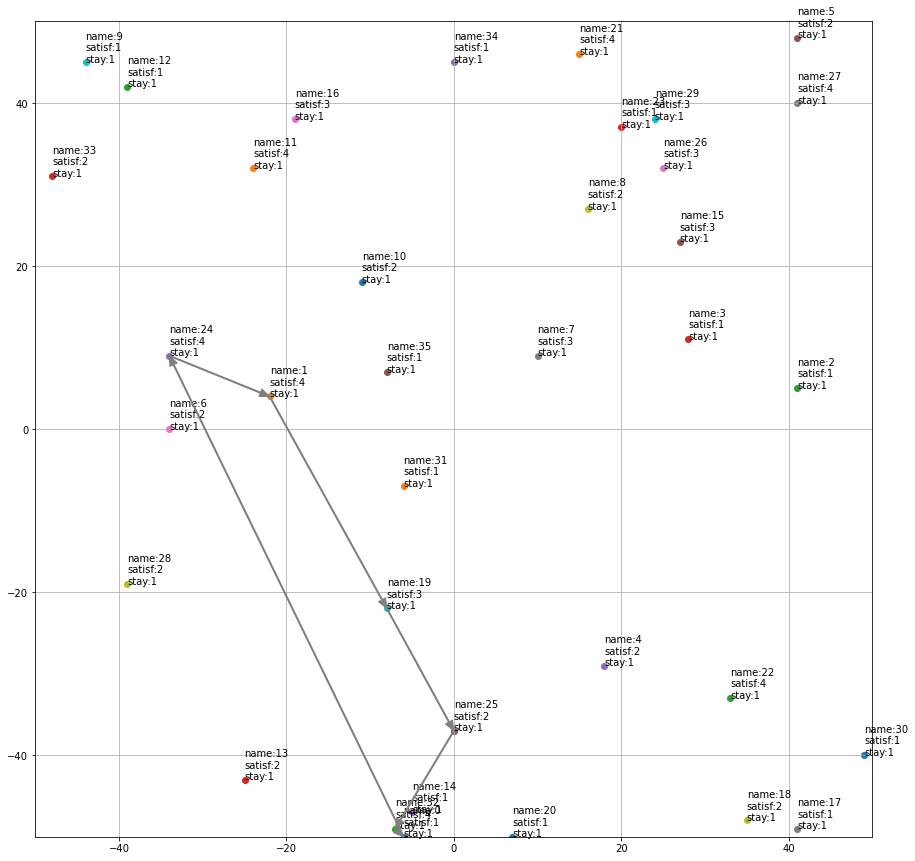

In [72]:
plt.figure(figsize=(15,15))

for pos_i, name_i, a_i, b_i in zip(pos, map(str, I), map(str, a), map(str, b)):
    plt.scatter(pos_i[0], pos_i[1])
    plt.annotate(f'name:{name_i}\nsatisf:{a_i}\nstay:{b_i}',
                 xy=(pos_i[0], pos_i[1]))

for i in I:
    for j in I:
        if i != j and x[i,j].value() == 1:
            plt.annotate('', xy=pos[i], xytext=pos[j], 
                         arrowprops=dict(shrink=0, width=1, headwidth=8, 
                                         headlength=10, connectionstyle='arc3',
                                         facecolor='gray', edgecolor='gray'))
                
plt.xlim([-R,R])
plt.ylim([-R,R])
plt.grid()
plt.show()